
# Viterbi decoding

This notebook demonstrates how to use Viterbi decoding to impose temporal
smoothing on frame-wise state predictions.

Our working example will be the problem of silence/non-silence detection.


In [1]:
# Code source: Brian McFee
# License: ISC

##################
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import librosa

Load an example signal



c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


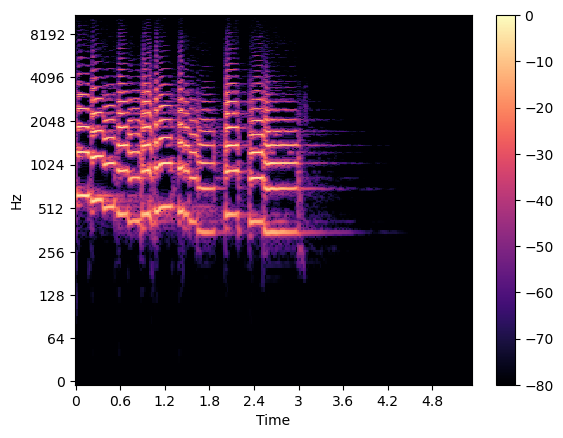

In [2]:
y, sr = librosa.load(librosa.ex('trumpet'))


# And compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))


###################
# Plot the spectrum
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_full, ref=np.max),
                               y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax);

As you can see, there are periods of silence and
non-silence throughout this recording.




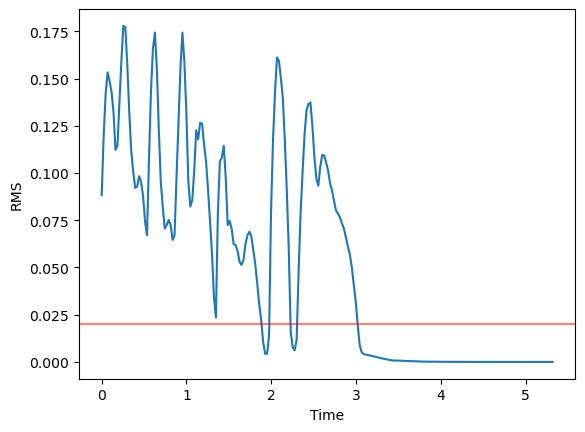

In [3]:
# As a first step, we can plot the root-mean-square (RMS) curve
rms = librosa.feature.rms(y=y)[0]

times = librosa.frames_to_time(np.arange(len(rms)))

fig, ax = plt.subplots()
ax.plot(times, rms)
ax.axhline(0.02, color='r', alpha=0.5)
ax.set(xlabel='Time', ylabel='RMS');

The red line at 0.02 indicates a reasonable threshold for silence detection.
However, the RMS curve occasionally dips below the threshold momentarily,
and we would prefer the detector to not count these brief dips as silence.
This is where the Viterbi algorithm comes in handy!



As a first step, we will convert the raw RMS score
into a likelihood (probability) by logistic mapping

  $P[V=1 | x] = \frac{\exp(x - \tau)}{1 + \exp(x - \tau)}$

where $x$ denotes the RMS value and $\tau=0.02$ is our threshold.
The variable $V$ indicates whether the signal is non-silent (1) or silent (0).

We'll normalize the RMS by its standard deviation to expand the
range of the probability vector



In [4]:
r_normalized = (rms - 0.02) / np.std(rms)
p = np.exp(r_normalized) / (1 + np.exp(r_normalized))

We can plot the probability curve over time:



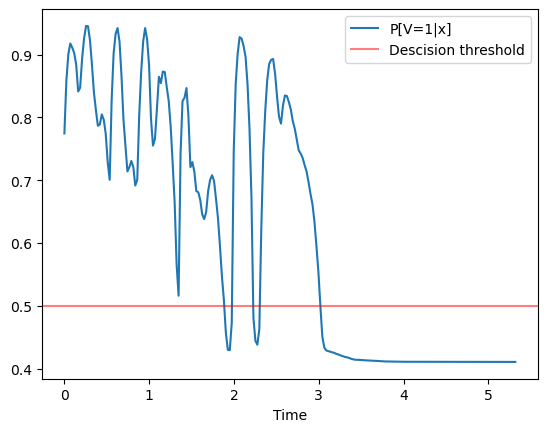

In [5]:
fig, ax = plt.subplots()
ax.plot(times, p, label='P[V=1|x]')
ax.axhline(0.5, color='r', alpha=0.5, label='Descision threshold')
ax.set(xlabel='Time')
ax.legend();

which looks much like the first plot, but with the decision threshold
shifted to 0.5.  A simple silence detector would classify each frame
independently of its neighbors, which would result in the following plot:



<Figure size 1200x600 with 0 Axes>

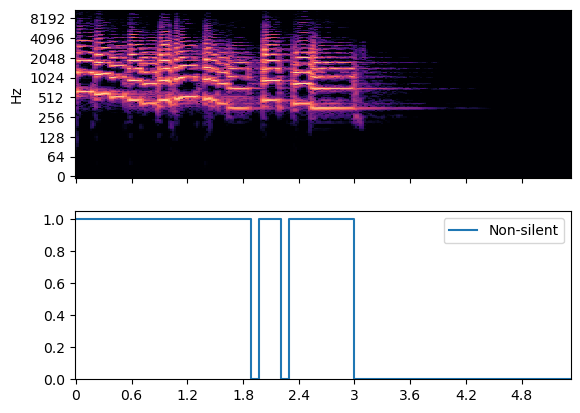

In [6]:
plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(S_full, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[0])
ax[0].label_outer()
ax[1].step(times, p>=0.5, label='Non-silent')
ax[1].set(ylim=[0, 1.05])
ax[1].legend()

We can do better using the Viterbi algorithm.
We'll use state 0 to indicate silent, and 1 to indicate non-silent.
We'll assume that a silent frame is equally likely to be followed
by silence or non-silence, but that non-silence is slightly
more likely to be followed by non-silence.
This is accomplished by building a self-loop transition matrix,
where `transition[i, j]` is the probability of moving from state
`i` to state `j` in the next frame.



In [7]:
transition = librosa.sequence.transition_loop(2, [0.5, 0.6])
print(transition)

[[0.5 0.5]
 [0.4 0.6]]


Our `p` variable only indicates the probability of non-silence,
so we need to also compute the probability of silence as its complement.



In [8]:
full_p = np.vstack([1 - p, p])
print(full_p)

[[0.22557992 0.14172441 0.09955996 0.08246648 0.08900833 0.09782773
  0.11637747 0.15879065 0.15290713 0.10642171 0.07418841 0.05446672
  0.0549953  0.07721573 0.11640877 0.16038394 0.1885227  0.21342498
  0.21139461 0.19533944 0.20374227 0.22636586 0.27143532 0.29951745
  0.17240483 0.09821182 0.06726509 0.05782145 0.07934618 0.13382572
  0.2034272  0.24540085 0.28605753 0.27937305 0.26941776 0.2792554
  0.30859733 0.2994945  0.19619691 0.12755245 0.07941294 0.05790144
  0.07562256 0.1165731  0.20322877 0.2450403  0.23386133 0.18626863
  0.13534808 0.14560008 0.12699723 0.12807924 0.15231961 0.17440844
  0.21581095 0.27354234 0.33623517 0.43460763 0.48399287 0.25713336
  0.17415017 0.16882974 0.15344495 0.19861054 0.27945876 0.27131325
  0.28638357 0.31745416 0.31924272 0.3316443  0.35461712 0.36199337
  0.35072583 0.31771964 0.29938602 0.29216415 0.30131018 0.32971174
  0.36052036 0.4044851  0.45268172 0.4909054  0.54291505 0.570173
  0.570663   0.5268914  0.25398868 0.14684623 0.098

Now, we're ready to decode!
We'll use `viterbi_discriminative` here, since the inputs are
state likelihoods conditional on data (in our case, data is rms).



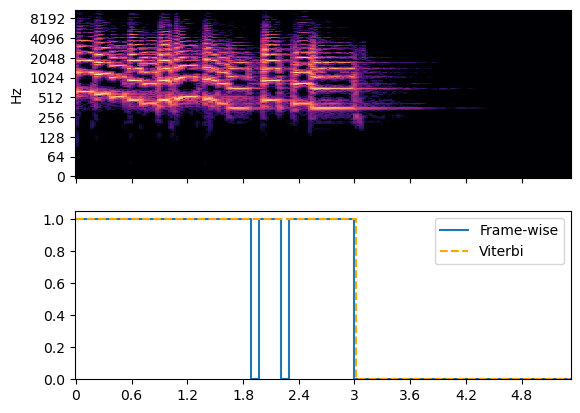

In [9]:
states = librosa.sequence.viterbi_discriminative(full_p, transition)

# sphinx_gallery_thumbnail_number = 5
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(S_full, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[0])
ax[0].label_outer()
ax[1].step(times, p>=0.5, label='Frame-wise')
ax[1].step(times, states, linestyle='--', color='orange', label='Viterbi')
ax[1].set(ylim=[0, 1.05])
ax[1].legend()

Note how the Viterbi output has fewer state changes than the frame-wise
predictor, and it is less sensitive to momentary dips in energy.
This is controlled directly by the transition matrix.
A higher self-transition probability means that the decoder is less
likely to change states.

